In [ ]:
#Extracting features from data
import os
import numpy as np
from keras.preprocessing.image import ImageDataGenerator

train_dir=r"C:\Users\skuma\OneDrive\Desktop\ML\DogsVsCat_data\train"
val_dir=r"C:\Users\skuma\OneDrive\Desktop\ML\DogsVsCat_data\val"
test_dir=r"C:\Users\skuma\OneDrive\Desktop\ML\DogsVsCat_data\test"

datagen=ImageDataGenerator(rescale=1./255)
batch_size=20

def extract_features(directory,sample_count):
    features=np.zeros(shape=(sample_count,150,150,3))
    labels=np.zeros(shape=(sample_count))
    generator=datagen.flow_from_directory(
        directory,
        target_size=(150,150),
        batch_size=batch_size,
        class_mode='binary'
    )
    i=0
    for inputs_batch,labels_batch in generator:
        features[i*batch_size:(i+1)*batch_size]=inputs_batch
        labels[i*batch_size:(i+1)*batch_size]=labels_batch
        i+=1
        if(i*batch_size>=sample_count):
            break
    return features,labels

train_features,train_labels=extract_features(train_dir,2000)
val_features,val_labels=extract_features(val_dir,1000)
test_features,test_labels=extract_features(test_dir,1000)

print("Train_Features: ",train_features.shape)
print("Val_Features:",val_features.shape)
print("Test_Features:",test_features.shape)
train_features2=train_features
val_features2=val_features
test_features2=test_features

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Train_Features:  (2000, 150, 150, 3)
Val_Features: (1000, 150, 150, 3)
Test_Features: (1000, 150, 150, 3)


In [22]:
#instantiating the VGG16 convulational base
from keras.applications import VGG16

conv_base=VGG16(weights='imagenet',
                include_top=False,#whether to include dense layer
                input_shape=(150,150,3)
                )
print(conv_base.summary())



Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 150, 150, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 150, 150, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 75, 75, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 75, 75, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 75, 75, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 37, 37, 128)       0     

In [ ]:
#Fast feature extraction without data augmentation
conv_base_features=conv_base.predict(train_features)
print("Output features shape:",conv_base_features.shape)

63/63 [==============================] - 737s 80ms/step
Output features shape: (2000, 4, 4, 512)


In [9]:
conv_base_val_features=conv_base.predict(val_features)
conv_base_test_features=conv_base.predict(test_features)
print("val features shape:",conv_base_val_features.shape)
print("test features shape:",conv_base_test_features.shape)

32/32 [==============================] - 2s 60ms/step
val features shape: (1000, 4, 4, 512)
test features shape: (1000, 4, 4, 512)


In [ ]:
#1st Method
train_features=np.reshape(conv_base_features,(2000,4*4*512))
test_features=np.reshape(conv_base_test_features,(1000,4*4*512))
val_features=np.reshape(conv_base_val_features,(1000,4*4*512))
#training
from keras import models, layers, optimizers
model=models.Sequential()
model.add(layers.InputLayer(input_shape=(4*4*512)))
model.add(layers.Dense(256,activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation='sigmoid'))
model.compile(optimizer=optimizers.RMSprop(lr=2e-5),
loss='binary_crossentropy',
metrics=['acc'])
history = model.fit(train_features, train_labels,
    epochs=30,
    batch_size=20,
    validation_data=(val_features, val_labels)
)


Epoch 1/30


C:\Users\skuma\anaconda3\envs\tf-gpu\lib\site-packages\keras\optimizers\optimizer_v2\rmsprop.py:140: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


100/100 [==============================] - 2s 9ms/step - loss: 0.5819 - acc: 0.6735 - val_loss: 0.4272 - val_acc: 0.8540
Epoch 2/30
100/100 [==============================] - 1s 6ms/step - loss: 0.4104 - acc: 0.8235 - val_loss: 0.3784 - val_acc: 0.8210
Epoch 3/30
100/100 [==============================] - 1s 6ms/step - loss: 0.3334 - acc: 0.8525 - val_loss: 0.3172 - val_acc: 0.8770
Epoch 4/30
100/100 [==============================] - 1s 6ms/step - loss: 0.2999 - acc: 0.8785 - val_loss: 0.2908 - val_acc: 0.8920
Epoch 5/30
100/100 [==============================] - 1s 6ms/step - loss: 0.2805 - acc: 0.8860 - val_loss: 0.2739 - val_acc: 0.8940
Epoch 6/30
100/100 [==============================] - 1s 6ms/step - loss: 0.2543 - acc: 0.9065 - val_loss: 0.2639 - val_acc: 0.8980
Epoch 7/30
100/100 [==============================] - 1s 8ms/step - loss: 0.2377 - acc: 0.9045 - val_loss: 0.2572 - val_acc: 0.9010
Epoch 8/30
100/100 [==============================] - 1s 7ms/step - loss: 0.2179 - acc:

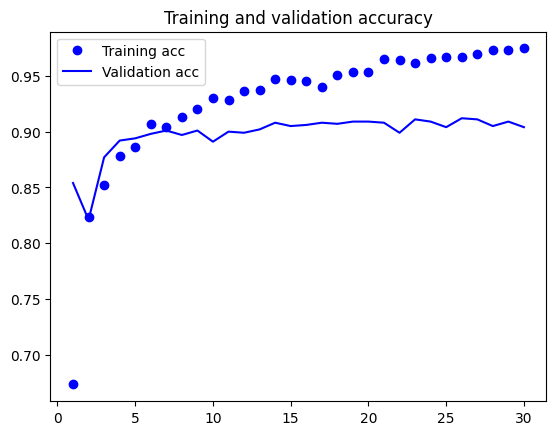

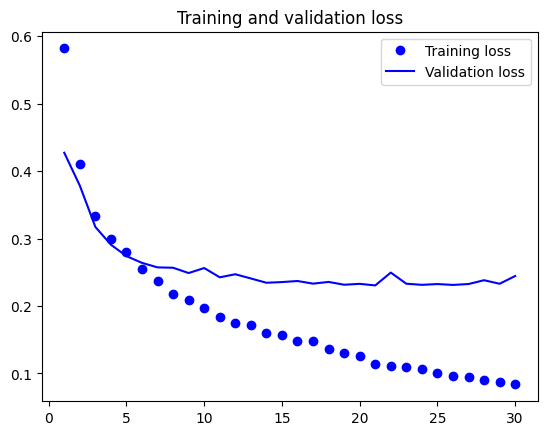

In [13]:
#Plotting of validation and accuracy
import matplotlib.pyplot as plt
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [29]:
#2nd Method
#Feature extraction with data augmentation
#slower than previous
model2=models.Sequential()
model2.add(conv_base)
model2.add(layers.Flatten())
model2.add(layers.Dense(256,activation='relu'))
model2.add(layers.Dense(1, activation='sigmoid'))

print(model2.summary())
print('This is the number of trainable weights '
'before freezing the conv base:', len(model2.trainable_weights))
conv_base.trainable =False
print('This is the number of trainable weights '
'after freezing the conv base:', len(model2.trainable_weights))

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 flatten_6 (Flatten)         (None, 8192)              0         
                                                                 
 dense_18 (Dense)            (None, 256)               2097408   
                                                                 
 dense_19 (Dense)            (None, 1)                 257       
                                                                 
Total params: 16,812,353
Trainable params: 16,812,353
Non-trainable params: 0
_________________________________________________________________
None
This is the number of trainable weights before freezing the conv base: 30
This is the number of trainable weights after freezing the conv base: 4


In [30]:
#training the model end to end with a frozen convolution base
#Data Augmentation
train_datagen=ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
    )

test_datagen=ImageDataGenerator(
    rescale=1./255
)

train_generator=train_datagen.flow_from_directory(
    train_dir,
    target_size=(150,150),
    batch_size=20,
    class_mode='binary'
)

val_generator=test_datagen.flow_from_directory(
    val_dir,
    target_size=(150,150),
    batch_size=20,
    class_mode='binary'
)

model2.compile(loss='binary_crossentropy',
               optimizer=optimizers.RMSprop(learning_rate=2e-5),
               metrics=['acc']
               )

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [31]:
#training
history2=model2.fit_generator(
    train_generator,
    steps_per_epoch=100,
    epochs=30,
    validation_data=val_generator,
    validation_steps=50
)

C:\Users\skuma\AppData\Local\Temp\ipykernel_8796\3585496431.py:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history2=model2.fit_generator(


Epoch 1/30
100/100 [==============================] - 20s 192ms/step - loss: 0.6019 - acc: 0.6690 - val_loss: 0.4459 - val_acc: 0.8130
Epoch 2/30
100/100 [==============================] - 19s 186ms/step - loss: 0.4790 - acc: 0.7775 - val_loss: 0.3534 - val_acc: 0.8660
Epoch 3/30
100/100 [==============================] - 19s 186ms/step - loss: 0.4259 - acc: 0.8135 - val_loss: 0.3132 - val_acc: 0.8730
Epoch 4/30
100/100 [==============================] - 19s 192ms/step - loss: 0.4032 - acc: 0.8145 - val_loss: 0.2967 - val_acc: 0.8710
Epoch 5/30
100/100 [==============================] - 19s 189ms/step - loss: 0.3713 - acc: 0.8400 - val_loss: 0.2804 - val_acc: 0.8830
Epoch 6/30
100/100 [==============================] - 19s 190ms/step - loss: 0.3637 - acc: 0.8430 - val_loss: 0.2697 - val_acc: 0.8860
Epoch 7/30
100/100 [==============================] - 19s 194ms/step - loss: 0.3573 - acc: 0.8415 - val_loss: 0.2585 - val_acc: 0.8970
Epoch 8/30
100/100 [==============================] - 1

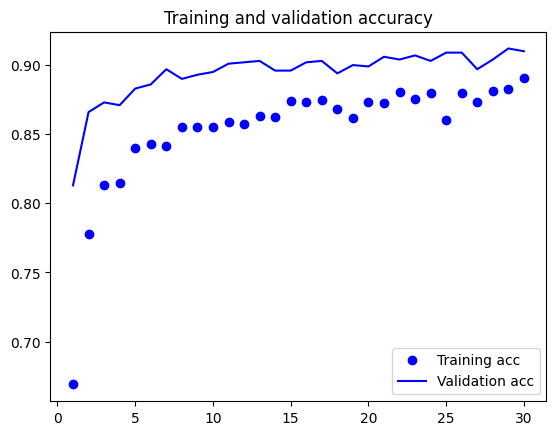

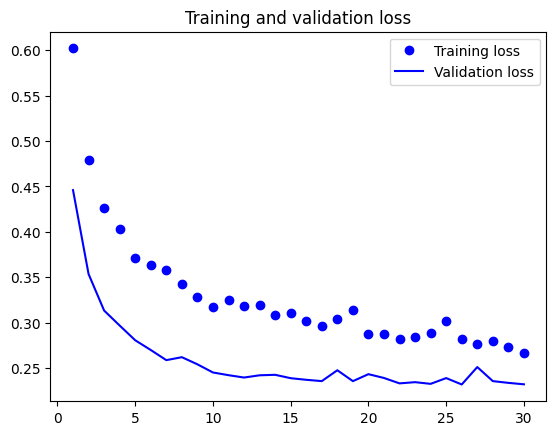

In [32]:
plt.clf()
acc = history2.history['acc']
val_acc = history2.history['val_acc']
loss = history2.history['loss']
val_loss = history2.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [33]:
print(conv_base.summary())

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 150, 150, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 150, 150, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 75, 75, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 75, 75, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 75, 75, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 37, 37, 128)       0     

In [37]:
#Fine tunning- Fine-tuning consists of unfreezing a few of
# the top layers of a frozen model base used for feature extraction, and jointly training
# both the newly added part of the model (in this case, the fully connected classifier)
# and these top layers.
conv_base.trainable=True
Layer=['block5_conv1','block5_conv2','block5_conv3','block5_pool']
for layer in conv_base.layers:
    if layer.name in Layer:
        layer.trainable=True
    else:
        layer.trainable=False
    print("name of layer :",layer.name," ",layer.trainable)
    

name of layer : input_4   False
name of layer : block1_conv1   False
name of layer : block1_conv2   False
name of layer : block1_pool   False
name of layer : block2_conv1   False
name of layer : block2_conv2   False
name of layer : block2_pool   False
name of layer : block3_conv1   False
name of layer : block3_conv2   False
name of layer : block3_conv3   False
name of layer : block3_pool   False
name of layer : block4_conv1   False
name of layer : block4_conv2   False
name of layer : block4_conv3   False
name of layer : block4_pool   False
name of layer : block5_conv1   True
name of layer : block5_conv2   True
name of layer : block5_conv3   True
name of layer : block5_pool   True


In [40]:
model2.compile(
    loss='binary_crossentropy',
    optimizer=optimizers.RMSprop(learning_rate=1e-5),
    metrics=['acc']
)
history3=model2.fit_generator(
    train_generator,
    steps_per_epoch=100,
    epochs=100,
    validation_data=val_generator,
    validation_steps=50
)

C:\Users\skuma\AppData\Local\Temp\ipykernel_8796\3141582302.py:6: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history3=model2.fit_generator(


Epoch 1/100
100/100 [==============================] - 202s 204ms/step - loss: 0.2929 - acc: 0.8730 - val_loss: 0.2404 - val_acc: 0.9040
Epoch 2/100
100/100 [==============================] - 20s 198ms/step - loss: 0.2616 - acc: 0.8900 - val_loss: 0.2061 - val_acc: 0.9140
Epoch 3/100
100/100 [==============================] - 19s 193ms/step - loss: 0.2428 - acc: 0.8965 - val_loss: 0.1996 - val_acc: 0.9170
Epoch 4/100
100/100 [==============================] - 20s 199ms/step - loss: 0.2187 - acc: 0.9050 - val_loss: 0.1849 - val_acc: 0.9250
Epoch 5/100
100/100 [==============================] - 20s 196ms/step - loss: 0.2026 - acc: 0.9195 - val_loss: 0.1859 - val_acc: 0.9300
Epoch 6/100
100/100 [==============================] - 19s 187ms/step - loss: 0.1904 - acc: 0.9245 - val_loss: 0.2460 - val_acc: 0.9140
Epoch 7/100
100/100 [==============================] - 20s 200ms/step - loss: 0.1768 - acc: 0.9330 - val_loss: 0.1959 - val_acc: 0.9310
Epoch 8/100
100/100 [==========================

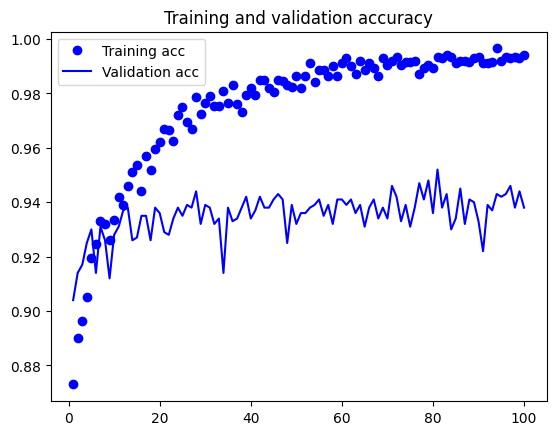

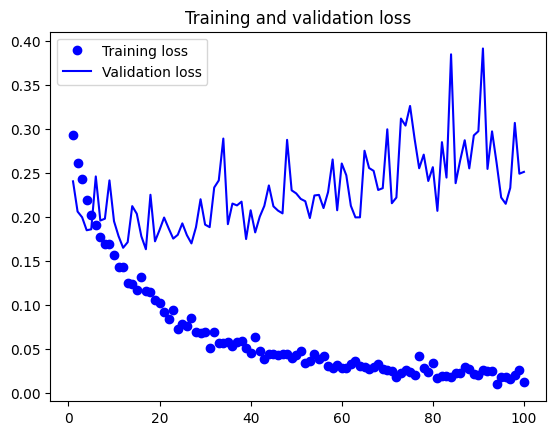

In [41]:
plt.clf()
acc = history3.history['acc']
val_acc = history3.history['val_acc']
loss = history3.history['loss']
val_loss = history3.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

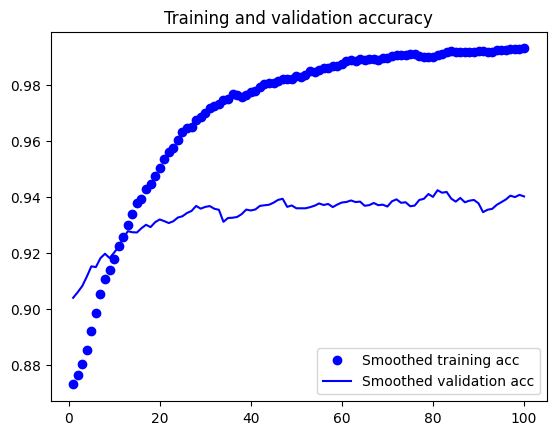

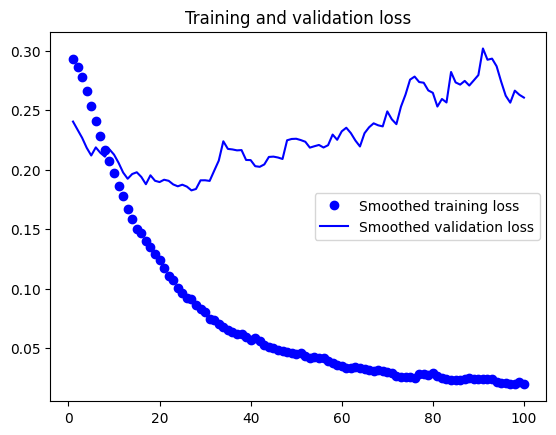

In [44]:
#to obtain smooth curve
def smooth_curve(points,factor=0.8):
    smoothed_points=[]
    for point in points:
        if smoothed_points:
            previous=smoothed_points[-1]
            smoothed_points.append(previous*factor+point*(1-factor))
        else:
            smoothed_points.append(point)
    return smoothed_points
plt.clf()
plt.plot(epochs,smooth_curve(acc), 'bo', label='Smoothed training acc')
plt.plot(epochs,smooth_curve(val_acc), 'b', label='Smoothed validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs,
smooth_curve(loss), 'bo', label='Smoothed training loss')
plt.plot(epochs,
smooth_curve(val_loss), 'b', label='Smoothed validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [45]:
#Evaluation of Model
test_generator=test_datagen.flow_from_directory(
    test_dir,
    target_size=(150,150),
    batch_size=20,
    class_mode='binary'
)

test_loss,test_acc=model2.evaluate_generator(test_generator,steps=50)
print("Test Accuracy: ",test_acc)
print("Test Loss: ",test_loss)

Found 1000 images belonging to 2 classes.


C:\Users\skuma\AppData\Local\Temp\ipykernel_8796\2699248958.py:9: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  test_loss,test_acc=model2.evaluate_generator(test_generator,steps=50)


Test Accuracy:  0.9340000152587891
Test Loss:  0.2977502942085266
